In [2]:
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision import transforms
import numpy as np
from torchvision.datasets import FashionMNIST
from hw2 import *

In [3]:
# a
# Implement the 90-degree rotation group (cyclic group) over a plane
class CyclicGroup():
    def __init__(self) -> None:
        super().__init__()
        self.order = len(self.elements())
    def elements(self):
        '''Returns the elements of the group
        @:return elements: torch.tensor of group elements
        '''
        return torch.arange(0, 4)
    def product(self, g,f):
        '''Returns the group product of a and b
        @:param g: first group element
        @:param f: second group element
        @:return out: composition of g with f
        '''
        return torch.remainder(g + f, 4)
    def inverse(self, g):
        '''Returns the inverse of a
        @:param g: group element to be inverted
        @:return out: inverse element of g
        '''
        return torch.remainder(-g, 4)
    def action(self, g, x, cat=True):
        '''Returns the group action of g on x
        @param g: group elements (tensor of group elements)
        @param x: input (shape [channels, height, width])
        '''
        if cat:
            out = torch.empty((len(g), *x.shape))
            for i,elem in enumerate(g.tolist()):
                out[i] = torch.rot90(x, elem, [-2,-1])
        else:
            out = []
            for elem in g.tolist():
                out.append(torch.rot90(x, elem, [-2,-1]))
        return out

(512, 512, 3)


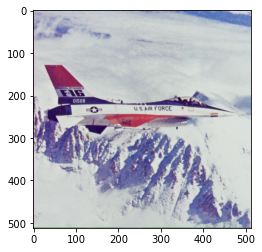

In [4]:
img = mpimg.imread("airplane.tiff")
print(img.shape)
plt.imshow(img)
plt.show()

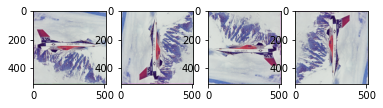

In [5]:
# Apply the group actions on an image and print (imshow) them
G = CyclicGroup()
elements = G.elements()
inp = transforms.ToTensor()(img)
rotated_imgs = G.action(elements, inp)
fig,axs = plt.subplots(1,4)
for i in range(4):
    axs[i].imshow(transforms.ToPILImage()(rotated_imgs[i]))
plt.show()

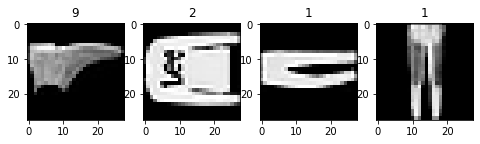

In [6]:
# b,c,d are all implemented in hw2.py
# e.i
test_transf = transforms.Compose([transforms.ToTensor(), RandomRot90()])
test = FashionMNIST(root='./data', train=False, transform=test_transf, download=True)
# show a few samples from the testing set
n_samples = 4
fig, axs = plt.subplots(1,n_samples, figsize=(n_samples*2,2))
for i in range(n_samples):
    sample = test[i]
    axs[i].imshow(sample[0].squeeze(), cmap='gray')
    axs[i].set_title(sample[1])
plt.show()

In [7]:
# b,c,d,e (i and ii) are all implemented in hw2.py
# here we just load the final model
# In order to train it again run hw2.py
checkpoint_file = "./model.pt"
model = torch.load(checkpoint_file)


FileNotFoundError: [Errno 2] No such file or directory: './model.pt'

In [25]:
# e.iii
# print accuracy on the test set
trainer = Trainer()
trainer.run_trainer()

Test:   0%|          | 0/79 [00:00<?, ?it/s]

Total accuracy: 84.130000%


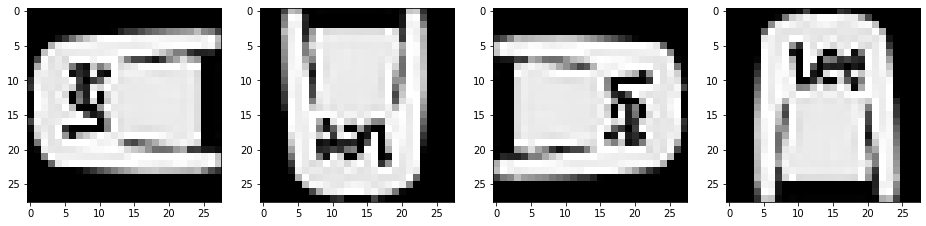

In [26]:
# show that the final representations are equivariant wrt 90-degree rotations
ex = test[1][0]
examples = torch.stack([torch.rot90(ex, i, dims=(-2,-1)) for i in range(4)])
fig, axs = plt.subplots(1,4, figsize=(16,16))
for i in range(4):
    axs[i].imshow(examples[i].squeeze(), cmap='gray')
plt.show()

In [34]:
# lift representation
# shape: (batch, hidden_channel, group_order, height, width)
examples = examples.to(trainer.device)
cpu = torch.device('cpu')
lifted_examples = trainer.model.convs[0](examples)
lifted_examples = lifted_examples.reshape(lifted_examples.shape[0], 
4, trainer.model.hidden_channel_number, lifted_examples.shape[2], lifted_examples.shape[3])

lifted_examples.shape


torch.Size([4, 4, 16, 28, 28])

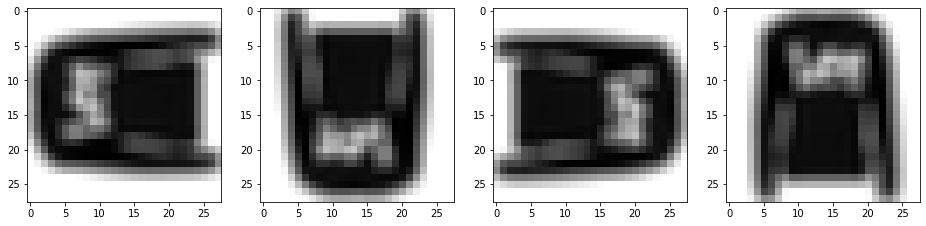

In [37]:
# as we can see applying the lifting convolutional layer to the rotated images
# results in a rotated representation, proving the equivariance of the layer
channel = 0
fig, axs = plt.subplots(1,lifted_examples.shape[0], figsize=(16,16))
for j in range(lifted_examples.shape[0]):
    axs[j].imshow(lifted_examples[j,0,channel].detach().to(cpu).numpy(), cmap='gray')
plt.show()

In [48]:
lifted_examples = trainer.model.convs[0](examples)
group_conv_examples = trainer.model.convs[2](lifted_examples)
group_conv_examples = group_conv_examples.reshape(group_conv_examples.shape[0], 
4, trainer.model.hidden_channel_number, group_conv_examples.shape[2], group_conv_examples.shape[3])
group_conv_examples.shape

torch.Size([4, 4, 16, 28, 28])

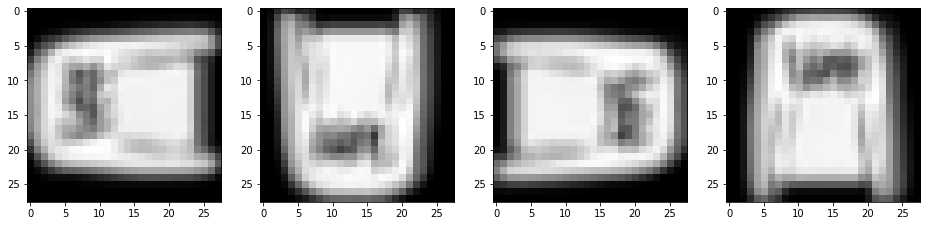

In [49]:
# as we can see applying the group convolutional layer to the rotated images
# results in a rotated representation, proving the equivariance of the layer
channel = 0
fig, axs = plt.subplots(1,group_conv_examples.shape[0], figsize=(16,16))
for j in range(group_conv_examples.shape[0]):
    axs[j].imshow((group_conv_examples[j,0,channel].detach().to(cpu).numpy()), cmap='gray')
plt.show()

In [50]:
projected_examples = trainer.model.convs(examples)
projected_examples = projected_examples.reshape(projected_examples.shape[0],4,trainer.model.hidden_channel_number,
projected_examples.shape[2], projected_examples.shape[3])
projected_examples = projected_examples.mean(dim=[1, -2, -1])

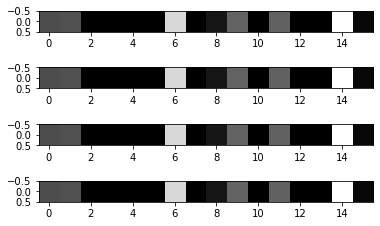

In [51]:
# as we can see after the coarsening of the network obtained after the pooling
# operation, the network yiedls the exact same representation for all the rotated images
# proving the complete invariance of the network to rotations
fig, axs = plt.subplots(len(CyclicGroup().elements()))
for i in range(len(CyclicGroup().elements())):
    axs[i].imshow(projected_examples[i, None].detach().to(cpu).numpy(), cmap='gray')
plt.show()

In [56]:
# e.iv
# test the model against rotations in [0,2pi]
# Repeat the experiment with random rotations in [0, 2π)
test_all_rotations_transf = transforms.Compose([transforms.ToTensor(), transforms.RandomRotation(degrees=(0, 360))])

# Load data
test_all_rotations = FashionMNIST(root='./data', train=False, transform=test_all_rotations_transf, download=True)
test_all_rotations_dl = torch.utils.data.DataLoader(test_all_rotations, batch_size=128, shuffle=False, pin_memory = True)

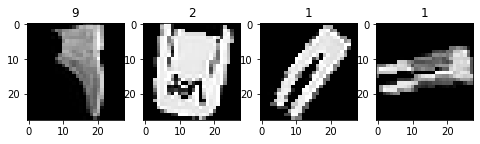

In [57]:
# show a few samples from the training set
n_samples = 4
fig, axs = plt.subplots(1,n_samples, figsize=(n_samples*2,2))
for i in range(n_samples):
    sample = test_all_rotations[i]
    axs[i].imshow(sample[0].squeeze(), cmap='gray')
    axs[i].set_title(sample[1])
plt.show()

In [58]:
# accuracy of the model with random rotations in [0, 2π)
# As we can see the accuracy of the model drops significantly when the rotations are not in [0, 90, 180, 270]
# This is due to the fact that the model is not equivariant to rotations in [0, 2pi)
# In order to improve the performance of the model we could make the network
# work with a cyclic group of bigger order covering the aforementioned range of rotations
total_accuracy = 0
model = trainer.model
model.eval()
with torch.no_grad():
    with tqdm(test_all_rotations_dl, desc=f'Test') as pbar:
        for inp, target in pbar:
            accuracy, _, target = trainer.forward(inp, target)
            total_accuracy += accuracy*len(inp)
            pbar.set_postfix(accuracy=f"{accuracy:0%}")
print(f"Total accuracy: {total_accuracy/len(test_all_rotations):0%}")

Test:   0%|          | 0/79 [00:00<?, ?it/s]

Total accuracy: 35.470000%
